# WeatherPy
----
### Background / Issues
* Goal:  rigorous, data-driven, qualitative model of the relationship between weather conditions and latitude
* Basic approach:  sample key current weather conditions (temperature, humidity, wind speed, and cloud cover) around the world using  OpenWeatherMap API queries by city, then test hypotheses about the correlation between these conditions and latitude
* Issues:  "City weather" is different from weather in general.  Cities are on land, tend to be near large bodies of water, and tend not to be at high elevation, in polar regions, on rugged terrain, in deserts, etc.  As a result, the model will test hypotheses about the relationship between current weather conditions near population centers and latitude
* Please see the "README" deisgn doc for more detailed discussion and instructions for use.


### Analysis Summary
* As expected, the weather becomes significantly warmer as one approaches the equator (0 Deg. Latitude). More interestingly, however, is the fact that the southern hemisphere tends to be warmer this time of year than the northern hemisphere. This may be due to the tilt of the earth.
* There is no strong relationship between latitude and cloudiness. However, it is interesting to see that a strong band of cities sits at 0, 80, and 100% cloudiness.
* There is no strong relationship between latitude and wind speed. However, in northern hemispheres there is a flurry of cities with over 20 mph of wind.

In [164]:
# Dependencies and Setup -- standard tools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# We also need some t-statistics
from scipy.stats import t
# We will make use of some Unix dates
from datetime import datetime
# and time.sleep to control server load
import time
# To manage API calls, we will use the openweathermapy functions and the API key
import openweathermapy.core as owm
from config import api_key
# To handle HTTP errors generated with openweathermapy, we need urllib
import urllib
# To correctly calculate minimum distances on the surface of the Earth, we need the haversine function
from haversine import haversine
# Input File (CSV)
input_data_file = 'citipy/worldcities.csv'
# Output File (CSV)
output_data_file = 'output_data/cities.csv'
# Log File (TXT)
output_log = 'output_data/log.txt'

### Code Parameters 

In [165]:
# lat_radius sets the maximum distance a city can be from a search point (in deg latitude, 
# which means 1.0 = 111 km, 2.0 = 222 km, etc).  Smaller = less efficient building of city lists
# but larger = more biased sampling of cities on coastlines and edges of populated regions 
lat_radius = 1.0
# Querying will stop once the number of cities with valid weather data reaches data_size,
# but in order to avoid an infinite query loop and manage server load, queries will be 
# done in sets of batch_size, with max_batches being the overriding limiting factor.
# To make sure queries do not stop before reaching data_size, set max_batches > 1.6 * data_size / batch_size
batch_size = 20
data_size = 100
max_batches = 5
# In order to keep the program from running an infinite loop while searching for cities to query,
# wlr sets the ratio of attempts to the target number to be found.  Because oceans cover the majority
# of Earth's surface, for random sampling to work, wlr should be at least 3, preferably about 2x larger.
# If the city search comes up short of its target, the notebook will ask you to increase wlr or lat_radius.
wlr = 6        #Use an integer

### Prepare City Data
By importing directly from the csv, we lose the kd-tree structure from citipy, but we gain much improved sampling capability.

In [166]:
# Create a DataFrame from the citipy input file, sort by latitude (then longitude), and use the latitude as the index
city_df = pd.read_csv(input_data_file).sort_values(by=['Latitude','Longitude']).set_index('Latitude', drop=False)
# A latitude-based index will speed up the city search greatly
city_df.head()

,Country,City,Latitude,Longitude
Latitude,,,,
-54.800000,ar,ushuaia,-54.800000,-68.300000
-53.150000,cl,punta arenas,-53.150000,-70.916667
-51.622613,ar,rio gallegos,-51.622613,-69.218127
-46.600000,nz,bluff,-46.600000,168.333333
-46.400000,nz,invercargill,-46.400000,168.350000


## Generate Cities List

In [167]:
def getcities(batch=batch_size, radius = lat_radius, maxtries = wlr * batch_size, found = []):
    '''Returns a list of unique city names by random sampling of the surface of the Earth (assumes perfect sphere).
    The parameters are: 1) batch sets the target number of cities to return, defaults to notebook constant
                        2) radius sets the maximum distance from the target that a city can be (in equiv. deg lat)
                           which means 1.0 = 111.13 km, 2.0 = 222.26 km, etc., defaults to a notebook constant
                        3) maxtries sets the maximum number of attempts, defaults to a notebook constant
                        4) found sets a list of city names to exclude (useful if calling the function multiple times)
    This function depends on a latitude-sorted, latitude-indexed global DataFrame called city_df.  
    Larger values of radius will sample cities in a more biased way, but small values will require many tries.'''
# Variables for holding city names and search count.  For safety, function will stop at a fixed number of searches.
    cities = []   # Using a list ends up simpler than a set
    searches = 0
# Ignore capital letters, and merge into a set for checking.  
    found = [item.lower() for item in found]
# Loop through until we get the required number of successes or exhaust tries:
    while len(cities) <  batch and searches <  maxtries:
        city_name = ''
        max_dist = 111.13 * radius  #Converts latitude degrees to km, based on average radius of Earth
        # Choose a random point on Earth's surface, the arc cos part corrects for contraction of longitude near poles
        lat = 180.0 / 3.1416 *  np.arccos(2 * np.random.rand() -1) - 90
        lng = 360.0 * np.random.rand() - 180.0
        # The search is a two-part filter.  The first is a fast filter by lat to speed up the search.
        # We do not filter on lngs because the modular arithmetic and nonlinearity make it quite complex.  
        search_df = city_df.loc[lat - radius : lat + radius,:]
        # Now we can search through a much smaller list to look for the nearest city
        # Here we use df.iat for fast look-up, with only numbers for indices (city name = 1, lat = 2, lng = 3)
        if not search_df.empty:
            #Some latitudes will have no cities, so these get skipped altogether
            for ix in range(len(search_df)):
                dist = haversine((lat, lng),(search_df.iat[ix,2],search_df.iat[ix,3]))
            # The second part of the search finds the minimum excluding anything in found 
                if (dist < max_dist) and (not search_df.iat[ix,1] in found):
                    city_name = search_df.iat[ix,1]
                    max_dist = dist
        # Append the nearest city if one was found
        if city_name:
            cities.append(city_name)
        searches += 1
    # After the loop, cut out any "within batch" duplicates
    cities = list(set(cities))
    if len(cities) < batch:
        print('Fewer cities found than targeted. Increase lat_radius and/or wlr to correct if needed.')
    print(f'Batch complete, {len(cities)} found.')
    return cities

### Perform API Calls


In [168]:
# Create settings for API call
settings = {'units':'imperial','appid':api_key}
# Set up objects to hold results and count of attempts and successes
batch_num = 0
# The cities found will be in a list because we would like to keep it ordered
cityfound, countryfound, tempfound, humidfound, windfound,\
cloudfound, latfound, lngfound, whenfound  = ([] for i in range(9))
# Get the data in batches so as to not overwhelm server ...
with open(output_log,'w') as f:
    while len(cityfound) < data_size and batch_num < max_batches:
        # Initialize a batch
        batch_num += 1
        print(f'Building batch number {batch_num}')
        reqtime = datetime.now()
        f.write(f'Beginning data collection batch {batch_num} at: ' + reqtime.strftime('%m/%d/%Y, %H:%M:%S') +'\n')
        # Get cities in a batch
        citylist = getcities(batch_size, lat_radius, wlr*batch_size, cityfound)
        # Now attempt to access weather data for each
        for city in citylist:
            # Reset temp holders, using '-199' to signal missing numbers
            tmpcity, tmpcountry, tmptemp, tmphumid, tmpwind, tmpclouds, tmplat, tmplng, tmpwhen = \
            '','',-199,-199,-199,-199,-199,-199,-199
            # Log request
            print('Requesting weather for ' + city + '...')
            reqtime = datetime.now()
            f.write('Request city: ' + city + ' at ' + reqtime.strftime('%m/%d/%Y, %H:%M:%S') + '\n')
            # Make request from OpenWeatherMap
            try:
                weather = owm.get_current(city, **settings)
                # Store results in temporary objects for checking, enforce types for later
                tmpcity = weather['name']
                tmpcountry = weather['sys']['country']
                tmptemp = float(weather['main']['temp'])
                tmphumid = float(weather['main']['humidity'])
                tmpwind = float(weather['wind']['speed'])
                tmpclouds = float(weather['clouds']['all'])
                tmplat = float(weather['coord']['lat'])
                tmplng = float(weather['coord']['lon'])
                tmpwhen = weather['dt']
                # Log data 
                reqtime = datetime.now()
                f.write('Response at ' + reqtime.strftime('%m/%d/%Y, %H:%M:%S') + '\n')
                f.write('City: ' + tmpcity + ' Country: ' + tmpcountry)
                f.write(' Temp: ' + str(tmptemp) + ' Humidity: ' + str(tmphumid))       
                f.write(' Wind: ' + str(tmpwind) + ' Cloud cover: ' + str(tmpclouds))    
                f.write(' Lat: ' + str(tmplat) + ' Lng: ' + str(tmplng))
                f.write(' Indicated time:  ' + datetime.utcfromtimestamp(tmpwhen).strftime('%m/%d/%Y, %H:%M') + ' UTC\n')
            except urllib.request.HTTPError:
                print('HTTP Error')
                f.write('HTTP Request Failed\n')
            except KeyError:
                print('Weather data not found.')
                f.write('Weather data not found.\n')
            # Only record data if all missing values are filled in with meaningful data 
            if all ((tmpcity != '', tmpcountry !='', tmptemp > -199, tmphumid >=0,\
                        tmpwind >=0, tmpclouds >=0, tmplat >=-90, tmplng >=-180, tmpwhen >=-199)):
                print('Succes. City: '+ tmpcity + ' found. Raw data in file')
                f.write('Success.  Appending data.\n')
                cityfound.append(tmpcity)
                countryfound.append(tmpcountry)
                tempfound.append(tmptemp)
                humidfound.append(tmphumid)
                windfound.append(tmpwind)
                cloudfound.append(tmpclouds)
                latfound.append(tmplat)
                lngfound.append(tmplng)
                whenfound.append(datetime.utcfromtimestamp(tmpwhen))
            else: #If not all parameters were successful, note it and move on to next.
                print('There was a problem with this request.  Noted in file')
                f.write('Data does not meet criteria and will not be used.\n')
        if len(cityfound) < data_size:  #Pause requests if we need to get more
            print('Giving the server a break ...')
            time.sleep(3)
    # This part executes when the while loop is done
    print('Data collection ended')
    f.write(f'Data collection ended with {len(cityfound)} cities found.\n')
    unique_cities = len(set(cityfound))
    f.write(f'Uniqueness check shows {unique_cities} unique city names.\n')
    if unique_cities < len(cityfound):
        print('Duplicate city names found ... check DataFrame lat/lng entries for any actual repeats')

Building batch number 1
Batch complete, 20 found.
Requesting weather for muzaffarabad...
Succes. City: Muzaffarabad found. Raw data in file
Requesting weather for pozhva...
Succes. City: Pozhva found. Raw data in file
Requesting weather for el retorno...
Succes. City: El Retorno found. Raw data in file
Requesting weather for rolim de moura...
HTTP Error
There was a problem with this request.  Noted in file
Requesting weather for amapa...
Succes. City: Amapa found. Raw data in file
Requesting weather for villachuato...
Succes. City: Villachuato found. Raw data in file
Requesting weather for karpathos...
Succes. City: Karpathos found. Raw data in file
Requesting weather for vetovo...
Succes. City: Vetovo found. Raw data in file
Requesting weather for cheuskiny...
HTTP Error
There was a problem with this request.  Noted in file
Requesting weather for liling...
Succes. City: Liling found. Raw data in file
Requesting weather for udachnyy...
Succes. City: Udachnyy found. Raw data in file
Req

Succes. City: Greenville found. Raw data in file
Requesting weather for doctor phillips...
Succes. City: Doctor Phillips found. Raw data in file
Requesting weather for canico...
Succes. City: Canico found. Raw data in file
Requesting weather for xuchang...
Succes. City: Xuchang found. Raw data in file
Requesting weather for kyabe...
Succes. City: Kyabe found. Raw data in file
Requesting weather for tabuk...
Succes. City: Tabuk found. Raw data in file
Requesting weather for chaohu...
Succes. City: Chaohu found. Raw data in file
Requesting weather for itainopolis...
HTTP Error
There was a problem with this request.  Noted in file
Giving the server a break ...
Data collection ended


### Convert Raw Data to DataFrame

In [169]:
# Generate DataFrame with the results
weather_df = pd.DataFrame({'City':cityfound,'Country':countryfound,'Latitude':latfound,
                          'Longitude':lngfound,'Time':whenfound,'Temperature (deg F)':tempfound,
                          'Humidity (%)':humidfound,'Wind Speed (mph)':windfound,'Cloud Cover (%)':cloudfound})
weather_df.to_csv(output_data_file)
weather_df

,City,Country,Latitude,Longitude,Time,Temperature (deg F),Humidity (%),Wind Speed (mph),Cloud Cover (%)
0,Muzaffarabad,PK,34.37,73.47,2019-03-30 03:11:33,50.61,100.0,2.57,92.0
1,Pozhva,RU,59.09,56.08,2019-03-30 03:11:35,29.73,93.0,11.86,48.0
2,El Retorno,CO,2.33,-72.63,2019-03-30 03:11:36,74.91,90.0,2.13,24.0
3,Amapa,HN,15.09,-87.97,2019-03-30 03:10:09,72.75,64.0,4.70,20.0
4,Villachuato,MX,20.15,-101.64,2019-03-30 03:11:38,66.27,30.0,4.70,0.0
5,Karpathos,GR,35.51,27.21,2019-03-30 02:50:00,53.60,66.0,21.92,80.0
6,Vetovo,HR,45.42,17.79,2019-03-30 03:00:00,33.80,86.0,4.70,0.0
7,Liling,CN,27.65,113.49,2019-03-30 02:00:00,68.00,64.0,8.95,0.0
8,Udachnyy,RU,66.42,112.40,2019-03-30 03:11:44,25.14,74.0,3.36,0.0
9,Bayir,TR,37.27,28.22,2019-03-30 02:50:00,50.00,34.0,13.87,0.0


### Plotting the Data

#### Latitude vs. Temperature Plot

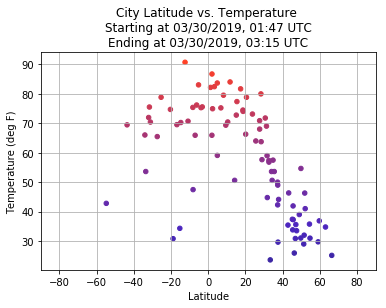

In [170]:
weather_df.plot(kind='scatter',x='Latitude',y='Temperature (deg F)',
                title='City Latitude vs. Temperature \n' +
                'Starting at %s UTC\n' % weather_df['Time'].min().strftime('%m/%d/%Y, %H:%M') +
                'Ending at %s UTC' % weather_df['Time'].max().strftime('%m/%d/%Y, %H:%M'),
                grid=True,xlim=(-90,90),c='Temperature (deg F)', colormap = 'CMRmap',
                vmax = 200, vmin = -20, colorbar = False)

plt.savefig('output_data/lat_v_temp.png')

#### Latitude vs. Humidity Plot

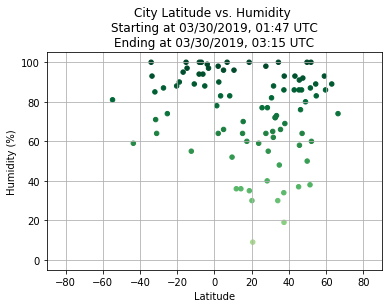

In [171]:
weather_df.plot(kind='scatter',x='Latitude',y='Humidity (%)',
                title='City Latitude vs. Humidity \n' +
                'Starting at %s UTC\n' % weather_df['Time'].min().strftime('%m/%d/%Y, %H:%M') +
                'Ending at %s UTC' % weather_df['Time'].max().strftime('%m/%d/%Y, %H:%M'),
                ylim = (-5, 105),
                grid=True,xlim=(-90,90),c='Humidity (%)', colormap = 'YlGn',
                vmax = 100, vmin = -50, colorbar = False)
plt.savefig('output_data/lat_v_humid.png')

#### Latitude vs. Cloudiness Plot

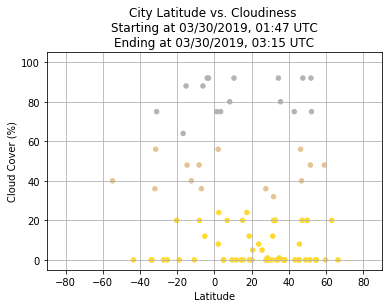

In [172]:
weather_df.plot(kind='scatter',x='Latitude',y='Cloud Cover (%)',
                title='City Latitude vs. Cloudiness \n' +
                'Starting at %s UTC\n' % weather_df['Time'].min().strftime('%m/%d/%Y, %H:%M') +
                'Ending at %s UTC' % weather_df['Time'].max().strftime('%m/%d/%Y, %H:%M'),
                ylim = (-5, 105),
                grid=True,xlim=(-90,90),c='Cloud Cover (%)', colormap = 'Set2',
                vmax = 100, vmin = -200, colorbar = False)
plt.savefig('output_data/lat_v_cloud.png')

#### Latitude vs. Wind Speed Plot

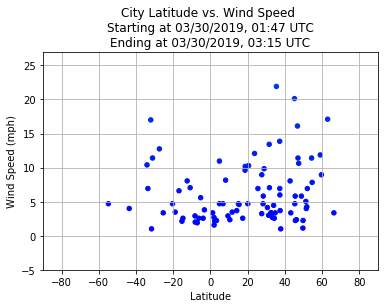

In [173]:
weather_df.plot(kind='scatter',x='Latitude',y='Wind Speed (mph)',
                title='City Latitude vs. Wind Speed \n' +
                'Starting at %s UTC\n' % weather_df['Time'].min().strftime('%m/%d/%Y, %H:%M') +
                'Ending at %s UTC' % weather_df['Time'].max().strftime('%m/%d/%Y, %H:%M'),
                ylim = (-5, weather_df['Wind Speed (mph)'].max() + 5),
                grid=True,xlim=(-90,90),c='Wind Speed (mph)', colormap = 'winter',
                vmax = 100, vmin = 0, colorbar = False)
plt.savefig('output_data/lat_v_wind.png')

### Statistical Analysis

* The latitude value will be used to check for northern vs. southern hemisphere effects
* A new column "Distance from Equator (km)" will be appended to DataFrame and used for analysis
* The key output variables will be Spearman (rank value) correlations because normality and linearity are not proven
* We will use t-test probabilities for the correlation coefficients, but we will treat 95-99% significance as marginal, in order to account for potential errors when using Spearman coefficients 

In [174]:
# First, add the new DataFrame column
weather_df['Distance from Equator (km)'] = abs(111.13 * weather_df['Latitude'])
# Then generate the matrix of correlation coefficients as a new DataFrame
rs_df = weather_df.corr(method='spearman')
rs_df

,Latitude,Longitude,Temperature (deg F),Humidity (%),Wind Speed (mph),Cloud Cover (%),Distance from Equator (km)
Latitude,1.000000,0.040194,-0.662796,-0.177473,0.176473,-0.141169,0.726268
Longitude,0.040194,1.000000,0.078705,-0.155433,0.070683,-0.191430,0.006503
Temperature (deg F),-0.662796,0.078705,1.000000,-0.073672,-0.115522,0.146501,-0.779186
Humidity (%),-0.177473,-0.155433,-0.073672,1.000000,-0.180066,0.420749,-0.138080
Wind Speed (mph),0.176473,0.070683,-0.115522,-0.180066,1.000000,-0.180415,0.296081
Cloud Cover (%),-0.141169,-0.191430,0.146501,0.420749,-0.180415,1.000000,-0.178869
Distance from Equator (km),0.726268,0.006503,-0.779186,-0.138080,0.296081,-0.178869,1.000000


Howell (2013) - Statistical Methods for Psychology (8th ed.). provides an approximate test for significant when using Spearman's correlation coefficients, basically the same formula as for Pearson values, but with the caution that the result is qualitative.  The accepted practice is simply to note borderline cases, so in this case we will label 95-99% confidence as " of marginal signficiance" and 99%+ as "likely significant"

In [175]:
#First, generate the significance thresholds for 95% and 99% (two-tailed) 
# These depend only on the degrees of freedom, which is N - 2.  
t95 = t.ppf(0.975,len(weather_df) - 2)
t99 = t.ppf(0.995,len(weather_df) - 2)
# Next, transform the DataFrame to generate t-values using the correlation coefficient formula,
# which is t = r * sqrt(N - 2) / sqrt(1-r^2)
t_df = rs_df.transform(lambda x: x * np.sqrt((len(weather_df) - 2)) / np.sqrt(1 - np.power(x,2)))
t_df

,Latitude,Longitude,Temperature (deg F),Humidity (%),Wind Speed (mph),Cloud Cover (%),Distance from Equator (km)
Latitude,inf,0.375209,-8.256084,-1.682056,1.672275,-1.330052,9.854623
Longitude,0.375209,inf,0.736397,-1.467623,0.660939,-1.819180,0.060659
Temperature (deg F),-8.256084,0.736397,inf,-0.689042,-1.084783,1.381372,-11.595147
Humidity (%),-1.682056,-1.467623,-0.689042,inf,-1.707450,4.326043,-1.300378
Wind Speed (mph),1.672275,0.660939,-1.084783,-1.707450,inf,-1.710875,2.891296
Cloud Cover (%),-1.330052,-1.819180,1.381372,4.326043,-1.710875,inf,-1.695724
Distance from Equator (km),9.854623,0.060659,-11.595147,-1.300378,2.891296,-1.695724,inf


In [176]:
# Finally, we will build a significance matrix using DataFrane cuts
# Define bins and labels
sig_bins = [np.NINF,-1 * t99, -1 * t95, t95, t99, np.PINF]
sig_labels = ['likely (-)','marginal (-)', 'no','marginal (+)','likely (+)']
# Buils a new DataFrame using dictionary comprehension
sig_df = pd.DataFrame({col : pd.cut(t_df[col],bins = sig_bins, labels = sig_labels, right = False) for col in t_df})
# Improve readability by blanking out NaN's
sig_df = sig_df.astype('str')
sig_df = sig_df.replace(to_replace='nan',value='')
sig_df

,Latitude,Longitude,Temperature (deg F),Humidity (%),Wind Speed (mph),Cloud Cover (%),Distance from Equator (km)
Latitude,,no,likely (-),no,no,no,likely (+)
Longitude,no,,no,no,no,no,no
Temperature (deg F),likely (-),no,,no,no,no,likely (-)
Humidity (%),no,no,no,,no,likely (+),no
Wind Speed (mph),no,no,no,no,,no,likely (+)
Cloud Cover (%),no,no,no,likely (+),no,,no
Distance from Equator (km),likely (+),no,likely (-),no,likely (+),no,
